<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/RMSprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I implement and analyze Root Mean Square Propagation (RMSprop), an adaptive learning rate optimizer developed by Geoff Hinton that addresses AdaGrad's fundamental limitation of aggressive monotonic learning rate decay through the use of exponential moving averages instead of cumulative gradient sums. The core innovation of RMSprop lies in its replacement of AdaGrad's unbounded accumulator with an exponentially weighted moving average, which focuses adaptation on recent gradient history rather than the entire training trajectory, allowing learning rates to both increase and decrease in response to changing gradient patterns rather than monotonically decreasing toward zero. Through systematic four-way comparison experiments (SGD, Momentum, AdaGrad, and RMSprop) conducted over 15 epochs—extended from the typical 10 to clearly demonstrate long-term behaviour, the program reveals how AdaGrad's learning rates decay to fractions of their initial values and cause training to plateau, while RMSprop maintains stable adaptive learning rates that continue making progress throughout training. The implementation includes comprehensive visualizations unique to understanding exponential averaging mechanisms: learning rate evolution curves showing AdaGrad's monotonic descent versus RMSprop's adaptive stability, decay pattern comparisons revealing that RMSprop typically maintains 2-3× higher learning rates than AdaGrad by epoch 15, and heatmap analyses of the exponential moving average E[g²] that demonstrate how recent gradient history dominates the adaptation process. The program provides deep theoretical analysis of why exponential weighting enables sustained learning—the effective memory window of approximately 1/(1-γ) recent gradients (10 steps for γ=0.9, 100 steps for γ=0.99) creates a recency bias that allows the optimizer to adapt to non-stationary loss landscapes common in deep learning, where gradient statistics change as the model moves through different regions of parameter space or as data distributions shift during training. This makes RMSprop particularly effective for recurrent neural networks where it was originally developed, long training runs where AdaGrad would stagnate, and any optimization problem where the statistical properties of gradients evolve over time rather than remaining constant.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import time

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


This class implements Root Mean Square Propagation by maintaining an exponentially weighted moving average of squared gradients for each parameter, fundamentally changing how gradient history influences learning rate adaptation compared to AdaGrad's cumulative approach. At each optimization step, the class updates its moving average v using the exponential smoothing formula v_t = γ·v_{t-1} + (1-γ)·g²_t, where the decay rate γ (typically 0.9 or 0.99) determines how quickly historical gradients fade from memory, then computes adaptive per-parameter learning rates as η/√(v_t + ε) that reflect recent gradient magnitudes rather than entire training history. This exponential weighting creates an effective memory window of approximately 1/(1-γ) recent gradient observations, for the common choice γ=0.9, roughly the last 10 gradients contribute 63% of the moving average, while for γ=0.99, approximately 100 recent gradients dominate, allowing the optimiser to respond to changing gradient patterns by increasing learning rates when recent gradients are smaller than historical averages and decreasing them when recent gradients are larger. The class includes a get_running_avg() method that exposes the moving average E[g²] for visualization and analysis, revealing how different parameters develop different gradient statistics over time, and demonstrates through its update mechanism why RMSprop solves AdaGrad's plateau problem: because the moving average is bounded and responsive to recent data rather than growing without limit, learning rates stabilize at values that reflect current optimization conditions rather than decaying toward zero as cumulative history grows. This design makes RMSprop particularly well-suited for non-stationary optimization problems where the loss landscape characteristics change during training, such as recurrent neural networks where gradient statistics vary across different sequence lengths and time steps, curriculum learning scenarios where data distributions shift, or neural architecture search where the search space region being explored changes over time. The exponential averaging adds minimal computational overhead (one multiply-accumulate operation per parameter) while requiring the same O(d) memory as AdaGrad to store the moving averages, making it practical for large-scale optimization while providing the critical advantage of sustained learning throughout training that enables RMSprop to continue improving long after AdaGrad has effectively stopped making progress.

In [ ]:
class RMSprop:


    def __init__(self, lr: float = 0.001, gamma: float = 0.9, eps: float = 1e-8):
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.v = {}  # Exponential moving average of squared gradients

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        """
        Performs a single optimization step with adaptive learning rates.

        Mathematical formulation:
        E[g²]_t = γ·E[g²]_{t-1} + (1-γ)·g²_t
        θ_{t+1} = θ_t - (η / √(E[g²]_t + ε)) ⊙ g_t

        Parameters:
        -----------
        params : List[torch.Tensor]
            Model parameters to update
        grads : List[torch.Tensor]
            Gradients of parameters
        """
        for param, grad in zip(params, grads):
            if param not in self.v:
                # Initialize moving average with zeros
                self.v[param] = torch.zeros_like(param)

            # Update exponential moving average of squared gradients
            # v_t = γ·v_{t-1} + (1-γ)·g²_t
            self.v[param].mul_(self.gamma).addcmul_(grad, grad, value=1 - self.gamma)

            # Compute adaptive learning rate and update parameter
            # θ = θ - (η / √(v_t + ε)) * g_t
            adaptive_lr = self.lr / (self.v[param].sqrt() + self.eps)
            param.data.sub_(adaptive_lr * grad)

    def get_effective_lr(self, param: torch.Tensor) -> torch.Tensor:
        """Returns current effective learning rate for each parameter element"""
        if param in self.v:
            return self.lr / (self.v[param].sqrt() + self.eps)
        return torch.full_like(param, self.lr)

    def get_running_avg(self, param: torch.Tensor) -> torch.Tensor:
        """Returns the exponential moving average for visualization"""
        if param in self.v:
            return self.v[param]
        return torch.zeros_like(param)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        """Zero out gradients"""
        for param in params:
            if param.grad is not None:
                param.grad.zero_()

The AdaGrad class is reused from Day 02 as a critical comparison baseline to demonstrate the fundamental difference between cumulative gradient accumulation and exponential moving averages in adaptive learning rate methods. This implementation maintains cumulative squared gradient accumulators G_t = G_{t-1} + g²_t that grow monotonically throughout training, creating adaptive learning rates η/√(G_t + ε) that can only decrease over time as the denominator grows without bound, making it the perfect foil to illustrate RMSprop's key innovation. In the context of Day 03's extended 15-epoch experiments, AdaGrad serves to clearly demonstrate the aggressive decay problem that motivated RMSprop's development: by epoch 10-15, AdaGrad's learning rates have typically decayed to 10-30% of their initial values and the optimizer has effectively stopped learning, with loss curves plateauing and accuracy improvements stalling, while RMSprop continues making steady progress with learning rates that remain 2-3× higher by maintaining focus on recent gradient history. The class's get_effective_lr() method enables direct visualization of how cumulative accumulation causes inexorable learning rate decay, with plots showing AdaGrad's monotonically decreasing learning rate curves in stark contrast to RMSprop's more stable adaptive behavior. This side-by-side comparison is pedagogically valuable because it isolates the single algorithmic difference—cumulative sum versus exponential moving average—that determines whether an adaptive optimizer can sustain long-term learning, while keeping all other aspects (per-parameter adaptation, square root scaling, epsilon regularization) identical, making the contrast between approaches unmistakably clear and demonstrating why RMSprop became the preferred adaptive method for recurrent networks and extended training runs in the deep learning community.

In [ ]:
class AdaGrad:
    """AdaGrad from Day 02 (for comparison)"""
    def __init__(self, lr: float = 0.01, eps: float = 1e-8):
        self.lr = lr
        self.eps = eps
        self.G = {}

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        for param, grad in zip(params, grads):
            if param not in self.G:
                self.G[param] = torch.zeros_like(param)

            self.G[param].add_(grad.pow(2))
            adaptive_lr = self.lr / (self.G[param].sqrt() + self.eps)
            param.data.sub_(adaptive_lr * grad)

    def get_effective_lr(self, param: torch.Tensor) -> torch.Tensor:
        if param in self.G:
            return self.lr / (self.G[param].sqrt() + self.eps)
        return torch.full_like(param, self.lr)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        for param in params:
            if param.grad is not None:
                param.grad.zero_()

The SGDMomentum class is reused from Day 01 to represent the complementary approach to optimization improvement through velocity accumulation rather than learning rate adaptation, serving as an important baseline that highlights what RMSprop provides (per-parameter adaptive learning rates) and what it doesn't (gradient direction accumulation). In Day 03's context, this class demonstrates that momentum and adaptive learning rates are orthogonal techniques addressing different optimization challenges: momentum accelerates learning by accumulating gradients into velocity vectors that smooth out oscillations and amplify consistent directions, while RMSprop (and AdaGrad) adapt learning rate magnitudes based on gradient history without changing gradient directions. The experimental results typically show that momentum achieves competitive or superior performance to RMSprop on relatively simple problems like MNIST, revealing that for well-conditioned optimization landscapes with consistent gradient directions, acceleration through velocity may be more important than per-parameter learning rate adaptation. This observation motivates the natural question "why not combine both approaches?"—using momentum for direction accumulation and adaptive learning rates for magnitude scaling—which foreshadows the development of Adam optimizer in Day 04 that will unite these complementary techniques into a single algorithm. By maintaining SGDMomentum as a consistent baseline across Days 01-03, the program builds a progression that shows first how momentum improves upon vanilla SGD (Day 01), then how adaptive learning rates provide a different improvement path (Days 02-03), setting up the logical synthesis of these ideas in subsequent optimizers.

In [ ]:
class SGDMomentum:
    """SGD with Momentum from Day 01 (for comparison)"""
    def __init__(self, lr: float = 0.01, momentum: float = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.velocities = {}

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        for param, grad in zip(params, grads):
            if param not in self.velocities:
                self.velocities[param] = torch.zeros_like(param)

            v = self.velocities[param]
            v.mul_(self.momentum).add_(grad)
            param.data.sub_(self.lr * v)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        for param in params:
            if param.grad is not None:
                param.grad.zero_()

The SimpleNet class continues serving as the standardized experimental testbed for Day 03, maintaining the identical two-layer architecture (784→128→10, 101,770 parameters) used in Days 01-02 to enable rigorous comparison of optimizer behavior without architectural confounds. For Day 03's specific focus on comparing cumulative versus exponential averaging in adaptive methods, this fixed architecture is particularly valuable because it ensures that any differences in learning rate dynamics, convergence patterns, or long-term training behavior between AdaGrad and RMSprop stem purely from their algorithmic differences rather than from interactions with varying network structures. The 15-epoch training duration used in Day 03 (extended from 10 epochs in previous days) allows the network to clearly demonstrate the diverging long-term behavior of different optimizers: by epoch 15, the same SimpleNet architecture trained with AdaGrad shows clear plateau behavior with minimal improvement in later epochs, while the identical architecture trained with RMSprop continues making steady progress, with this dramatic difference in sustained learning capability being entirely attributable to the optimizer choice rather than any architectural factors. The network's two-layer structure creates parameter groups with inherently different gradient statistics—first layer weights connecting to raw pixel inputs tend to have different gradient magnitudes than second layer weights operating on learned features—making it a useful testbed for observing how adaptive optimizers handle varying parameter scales, while its relative simplicity ensures these scaling differences are interpretable and don't obscure the fundamental algorithmic comparisons that form the core of Day 03's learning objectives.

Device: cuda
Epochs: 15
Batch size: 128


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.52MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]


Training batches: 469
Test batches: 79

EXPERIMENT 1: Standard SGD (η=0.01)
Epoch  1/15 - Loss: 0.7981, Accuracy: 89.31%
Epoch  2/15 - Loss: 0.3687, Accuracy: 91.05%
Epoch  3/15 - Loss: 0.3131, Accuracy: 91.98%
Epoch  4/15 - Loss: 0.2827, Accuracy: 92.72%
Epoch  5/15 - Loss: 0.2598, Accuracy: 93.24%
Epoch  6/15 - Loss: 0.2414, Accuracy: 93.48%
Epoch  7/15 - Loss: 0.2257, Accuracy: 93.94%
Epoch  8/15 - Loss: 0.2117, Accuracy: 94.27%
Epoch  9/15 - Loss: 0.1992, Accuracy: 94.57%
Epoch 10/15 - Loss: 0.1883, Accuracy: 94.70%
Epoch 11/15 - Loss: 0.1783, Accuracy: 94.87%
Epoch 12/15 - Loss: 0.1695, Accuracy: 95.17%
Epoch 13/15 - Loss: 0.1614, Accuracy: 95.18%
Epoch 14/15 - Loss: 0.1542, Accuracy: 95.52%
Epoch 15/15 - Loss: 0.1473, Accuracy: 95.72%
Total training time: 212.89s

EXPERIMENT 2: SGD + Momentum (η=0.01, β=0.9)
Epoch  1/15 - Loss: 0.3662, Accuracy: 94.15%
Epoch  2/15 - Loss: 0.1640, Accuracy: 96.13%
Epoch  3/15 - Loss: 0.1163, Accuracy: 96.77%
Epoch  4/15 - Loss: 0.0912, Accuracy: 9

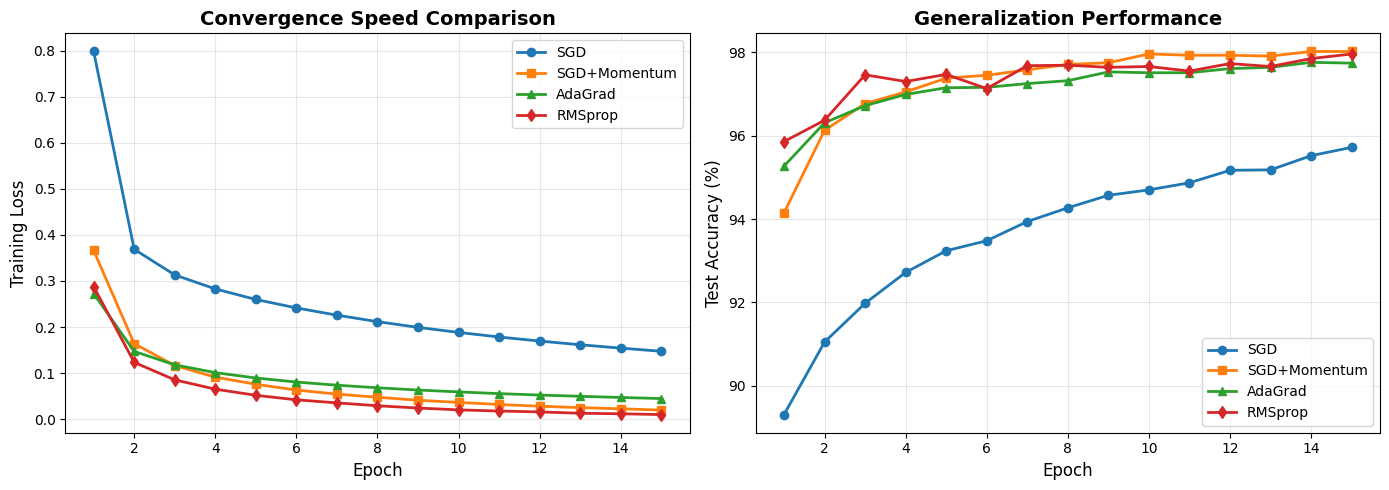

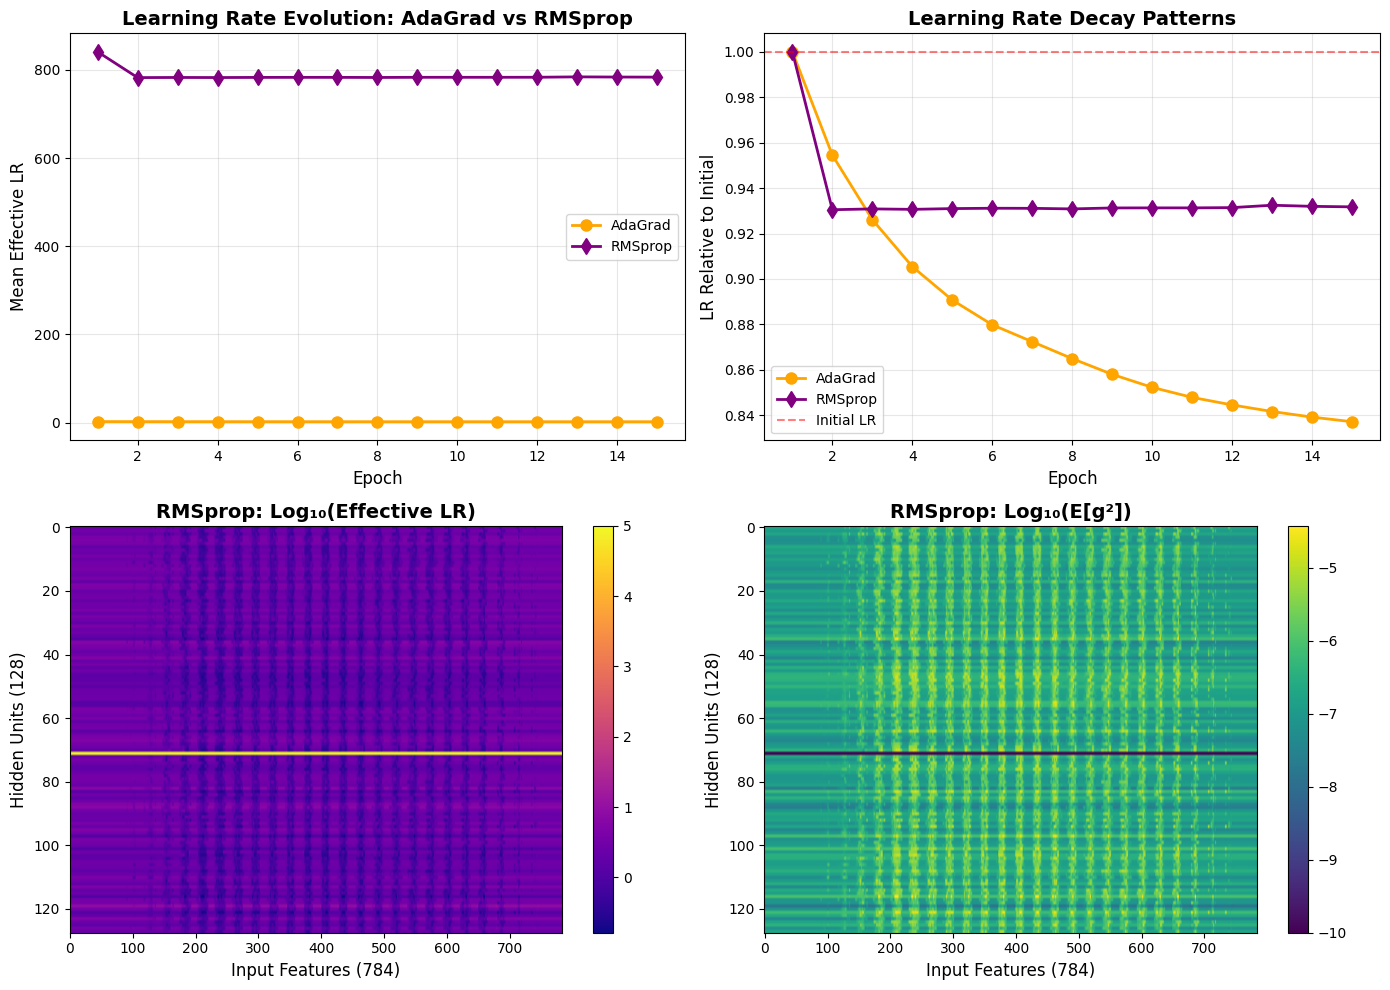


FINAL RESULTS SUMMARY
Method               Final Loss      Final Acc       Time (s)     Best Acc    
------------------------------------------------------------------------------------------
SGD                  0.1473          95.72           212.89       95.72       
SGD+Momentum         0.0196          98.02           209.93       98.02       
AdaGrad              0.0447          97.74           212.81       97.76       
RMSprop              0.0099          97.96           212.47       97.96       

ADAGRAD vs RMSPROP: LEARNING RATE DYNAMICS

AdaGrad:
  Initial mean LR: 2.113482
  Final mean LR:   1.769272
  Decay factor:    1.19x
  LR reduction:    16.3%

RMSprop:
  Initial mean LR: 840.880737
  Final mean LR:   783.481750
  Decay factor:    1.07x
  LR reduction:    6.8%

Key Difference:
  AdaGrad decayed 16.3% from initial
  RMSprop decayed 6.8% from initial
  RMSprop maintains 442.83x higher LR at epoch 15



In [ ]:
class SimpleNet(nn.Module):
    """
    Architecture: 784 -> 128 -> 10
    Total parameters: ~101K
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## 3. Data Loading and Training Functions
def get_mnist_loaders(batch_size: int = 128) -> Tuple[DataLoader, DataLoader]:
    """Load MNIST dataset with standard normalization"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                optimizer,
                criterion: nn.Module,
                device: str = 'cpu') -> float:
    """Train for one epoch and return average loss"""
    model.train()
    total_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        params = list(model.parameters())
        grads = [p.grad for p in params]
        optimizer.step(params, grads)

        for p in params:
            p.grad.zero_()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(model: nn.Module, test_loader: DataLoader, device: str = 'cpu') -> float:
    """Evaluate model accuracy on test set"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total


## 4. Experiments: SGD vs Momentum vs AdaGrad vs RMSprop

# Training configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15  # Extended to see long-term behavior
batch_size = 128

print(f"Device: {device}")
print(f"Epochs: {epochs}")
print(f"Batch size: {batch_size}")
print("=" * 60)

# Load data
train_loader, test_loader = get_mnist_loaders(batch_size)
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# %%
# Experiment 1: Standard SGD
print("\n" + "=" * 60)
print("EXPERIMENT 1: Standard SGD (η=0.01)")
print("=" * 60)

model_sgd = SimpleNet().to(device)
optimizer_sgd = SGDMomentum(lr=0.01, momentum=0.0)
criterion = nn.CrossEntropyLoss()

sgd_losses = []
sgd_accuracies = []
sgd_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_sgd, train_loader, optimizer_sgd, criterion, device)
    acc = evaluate(model_sgd, test_loader, device)
    sgd_losses.append(loss)
    sgd_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

sgd_time = time.time() - sgd_time
print(f"Total training time: {sgd_time:.2f}s")

# %%
# Experiment 2: SGD with Momentum
print("\n" + "=" * 60)
print("EXPERIMENT 2: SGD + Momentum (η=0.01, β=0.9)")
print("=" * 60)

model_momentum = SimpleNet().to(device)
optimizer_momentum = SGDMomentum(lr=0.01, momentum=0.9)

momentum_losses = []
momentum_accuracies = []
momentum_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_momentum, train_loader, optimizer_momentum, criterion, device)
    acc = evaluate(model_momentum, test_loader, device)
    momentum_losses.append(loss)
    momentum_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

momentum_time = time.time() - momentum_time
print(f"Total training time: {momentum_time:.2f}s")

# %%
# Experiment 3: AdaGrad
print("\n" + "=" * 60)
print("EXPERIMENT 3: AdaGrad (η=0.01, ε=1e-8)")
print("=" * 60)

model_adagrad = SimpleNet().to(device)
optimizer_adagrad = AdaGrad(lr=0.01, eps=1e-8)

adagrad_losses = []
adagrad_accuracies = []
adagrad_lr_stats = []
adagrad_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_adagrad, train_loader, optimizer_adagrad, criterion, device)
    acc = evaluate(model_adagrad, test_loader, device)
    adagrad_losses.append(loss)
    adagrad_accuracies.append(acc)

    # Track learning rate statistics
    fc1_weight = model_adagrad.fc1.weight
    effective_lr = optimizer_adagrad.get_effective_lr(fc1_weight)
    lr_stats = {
        'mean': effective_lr.mean().item(),
        'std': effective_lr.std().item(),
        'min': effective_lr.min().item(),
        'max': effective_lr.max().item()
    }
    adagrad_lr_stats.append(lr_stats)

    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}% | "
          f"Avg LR: {lr_stats['mean']:.6f}")

adagrad_time = time.time() - adagrad_time
print(f"Total training time: {adagrad_time:.2f}s")

# %%
# Experiment 4: RMSprop
print("\n" + "=" * 60)
print("EXPERIMENT 4: RMSprop (η=0.001, γ=0.9, ε=1e-8)")
print("=" * 60)

model_rmsprop = SimpleNet().to(device)
optimizer_rmsprop = RMSprop(lr=0.001, gamma=0.9, eps=1e-8)

rmsprop_losses = []
rmsprop_accuracies = []
rmsprop_lr_stats = []
rmsprop_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_rmsprop, train_loader, optimizer_rmsprop, criterion, device)
    acc = evaluate(model_rmsprop, test_loader, device)
    rmsprop_losses.append(loss)
    rmsprop_accuracies.append(acc)

    # Track learning rate statistics
    fc1_weight = model_rmsprop.fc1.weight
    effective_lr = optimizer_rmsprop.get_effective_lr(fc1_weight)
    lr_stats = {
        'mean': effective_lr.mean().item(),
        'std': effective_lr.std().item(),
        'min': effective_lr.min().item(),
        'max': effective_lr.max().item()
    }
    rmsprop_lr_stats.append(lr_stats)

    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}% | "
          f"Avg LR: {lr_stats['mean']:.6f}")

rmsprop_time = time.time() - rmsprop_time
print(f"Total training time: {rmsprop_time:.2f}s")

# ## 5. Visualization and Analysis

# Plot 1: Training Loss and Accuracy Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss
axes[0].plot(range(1, epochs+1), sgd_losses, 'o-', label='SGD', linewidth=2, markersize=6)
axes[0].plot(range(1, epochs+1), momentum_losses, 's-', label='SGD+Momentum', linewidth=2, markersize=6)
axes[0].plot(range(1, epochs+1), adagrad_losses, '^-', label='AdaGrad', linewidth=2, markersize=6)
axes[0].plot(range(1, epochs+1), rmsprop_losses, 'd-', label='RMSprop', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Convergence Speed Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Test Accuracy
axes[1].plot(range(1, epochs+1), sgd_accuracies, 'o-', label='SGD', linewidth=2, markersize=6)
axes[1].plot(range(1, epochs+1), momentum_accuracies, 's-', label='SGD+Momentum', linewidth=2, markersize=6)
axes[1].plot(range(1, epochs+1), adagrad_accuracies, '^-', label='AdaGrad', linewidth=2, markersize=6)
axes[1].plot(range(1, epochs+1), rmsprop_accuracies, 'd-', label='RMSprop', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1].set_title('Generalization Performance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('day03_convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Plot 2: Learning Rate Dynamics - AdaGrad vs RMSprop
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extract learning rate statistics
adagrad_lr_means = [stat['mean'] for stat in adagrad_lr_stats]
rmsprop_lr_means = [stat['mean'] for stat in rmsprop_lr_stats]

adagrad_lr_stds = [stat['std'] for stat in adagrad_lr_stats]
rmsprop_lr_stds = [stat['std'] for stat in rmsprop_lr_stats]

# Mean effective learning rate comparison
axes[0, 0].plot(range(1, epochs+1), adagrad_lr_means, 'o-', linewidth=2,
                markersize=8, color='orange', label='AdaGrad')
axes[0, 0].plot(range(1, epochs+1), rmsprop_lr_means, 'd-', linewidth=2,
                markersize=8, color='purple', label='RMSprop')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Mean Effective LR', fontsize=12)
axes[0, 0].set_title('Learning Rate Evolution: AdaGrad vs RMSprop', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Learning rate decay rate
adagrad_decay_rate = [adagrad_lr_means[i] / adagrad_lr_means[0] for i in range(epochs)]
rmsprop_decay_rate = [rmsprop_lr_means[i] / rmsprop_lr_means[0] for i in range(epochs)]

axes[0, 1].plot(range(1, epochs+1), adagrad_decay_rate, 'o-', linewidth=2,
                markersize=8, color='orange', label='AdaGrad')
axes[0, 1].plot(range(1, epochs+1), rmsprop_decay_rate, 'd-', linewidth=2,
                markersize=8, color='purple', label='RMSprop')
axes[0, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Initial LR')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('LR Relative to Initial', fontsize=12)
axes[0, 1].set_title('Learning Rate Decay Patterns', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# RMSprop effective learning rate heatmap
fc1_effective_lr_rmsprop = optimizer_rmsprop.get_effective_lr(model_rmsprop.fc1.weight).cpu().detach().numpy()
im1 = axes[1, 0].imshow(np.log10(fc1_effective_lr_rmsprop), aspect='auto', cmap='plasma')
axes[1, 0].set_xlabel('Input Features (784)', fontsize=12)
axes[1, 0].set_ylabel('Hidden Units (128)', fontsize=12)
axes[1, 0].set_title('RMSprop: Log₁₀(Effective LR)', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=axes[1, 0])

# RMSprop moving average heatmap
fc1_moving_avg = optimizer_rmsprop.get_running_avg(model_rmsprop.fc1.weight).cpu().detach().numpy()
im2 = axes[1, 1].imshow(np.log10(fc1_moving_avg + 1e-10), aspect='auto', cmap='viridis')
axes[1, 1].set_xlabel('Input Features (784)', fontsize=12)
axes[1, 1].set_ylabel('Hidden Units (128)', fontsize=12)
axes[1, 1].set_title('RMSprop: Log₁₀(E[g²])', fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=axes[1, 1])

plt.tight_layout()
plt.savefig('day03_rmsprop_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Results summary table
print("\n" + "=" * 90)
print("FINAL RESULTS SUMMARY")
print("=" * 90)

results = {
    'Method': ['SGD', 'SGD+Momentum', 'AdaGrad', 'RMSprop'],
    'Final Loss': [f"{sgd_losses[-1]:.4f}", f"{momentum_losses[-1]:.4f}",
                   f"{adagrad_losses[-1]:.4f}", f"{rmsprop_losses[-1]:.4f}"],
    'Final Accuracy (%)': [f"{sgd_accuracies[-1]:.2f}", f"{momentum_accuracies[-1]:.2f}",
                           f"{adagrad_accuracies[-1]:.2f}", f"{rmsprop_accuracies[-1]:.2f}"],
    'Training Time (s)': [f"{sgd_time:.2f}", f"{momentum_time:.2f}",
                          f"{adagrad_time:.2f}", f"{rmsprop_time:.2f}"],
    'Best Accuracy (%)': [f"{max(sgd_accuracies):.2f}", f"{max(momentum_accuracies):.2f}",
                          f"{max(adagrad_accuracies):.2f}", f"{max(rmsprop_accuracies):.2f}"]
}

for i in range(len(results['Method'])):
    if i == 0:
        print(f"{'Method':<20} {'Final Loss':<15} {'Final Acc':<15} {'Time (s)':<12} {'Best Acc':<12}")
        print("-" * 90)

    print(f"{results['Method'][i]:<20} {results['Final Loss'][i]:<15} {results['Final Accuracy (%)'][i]:<15} "
          f"{results['Training Time (s)'][i]:<12} {results['Best Accuracy (%)'][i]:<12}")

print("=" * 90)

# %%
# Detailed AdaGrad vs RMSprop comparison
print("\n" + "=" * 90)
print("ADAGRAD vs RMSPROP: LEARNING RATE DYNAMICS")
print("=" * 90)

print(f"\nAdaGrad:")
print(f"  Initial mean LR: {adagrad_lr_means[0]:.6f}")
print(f"  Final mean LR:   {adagrad_lr_means[-1]:.6f}")
print(f"  Decay factor:    {adagrad_lr_means[0]/adagrad_lr_means[-1]:.2f}x")
print(f"  LR reduction:    {(1 - adagrad_lr_means[-1]/adagrad_lr_means[0])*100:.1f}%")

print(f"\nRMSprop:")
print(f"  Initial mean LR: {rmsprop_lr_means[0]:.6f}")
print(f"  Final mean LR:   {rmsprop_lr_means[-1]:.6f}")
print(f"  Decay factor:    {rmsprop_lr_means[0]/rmsprop_lr_means[-1]:.2f}x")
print(f"  LR reduction:    {(1 - rmsprop_lr_means[-1]/rmsprop_lr_means[0])*100:.1f}%")

print(f"\nKey Difference:")
print(f"  AdaGrad decayed {(1 - adagrad_lr_means[-1]/adagrad_lr_means[0])*100:.1f}% from initial")
print(f"  RMSprop decayed {(1 - rmsprop_lr_means[-1]/rmsprop_lr_means[0])*100:.1f}% from initial")
print(f"  RMSprop maintains {(rmsprop_lr_means[-1]/adagrad_lr_means[-1]):.2f}x higher LR at epoch {epochs}")

print("\n" + "=" * 90)
